In [1]:
import torch
from torch.utils.data import Dataset, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os.path
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
if torch.has_cuda:
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
else:
    device = 'cpu'

device = torch.device(device)
print(device)

mps


In [3]:
# Data class for taxi
class taxiData(Dataset):
  def __init__(self, csv_file):
    if os.path.isfile('cached_dataframe.pkl'):
      df = pd.read_pickle('cached_dataframe.pkl')
    else:
      df = pd.read_csv(csv_file)
      df.to_pickle('cached_dataframe.pkl')
    all_xy = df.to_numpy()
    
#    tmp_x = all_xy[:,0:7]
 
    call_type_data =    np.array(all_xy[:,0:66]     )
    taxi_id_data =      np.array(all_xy[:,66:516]   )
    month_data =        np.array(all_xy[:,516:528]  )
    weekday_data =      np.array(all_xy[:,528:535]  )
    time_data =         np.array(all_xy[:,535:536]  , dtype=np.float32)
    daytype_data =      np.array(all_xy[:,536:539]  )
    triptime_data =     np.array(all_xy[:,539]      , dtype=np.float32)

    #print(np.concatenate([time_data, daytype_data], axis=1))

    all_data = torch.tensor(all_xy[:,0:539], dtype=torch.float32)
    tmp_x = all_data

#    tmp_x = torch.unsqueeze(all_data, 1)
#    tmp_x = tmp_x.repeat(1, 2, 1)
#    tmp_x = all_data.repeat(1, 2)

    tmp_x = tmp_x.to(device)
    print(tmp_x.shape)

#    print(tmp_x)
#    print(tmp_x.shape)
#    print(tmp_x[0].shape)
#    print(tmp_x.shape)

    #tmp_x = all_xy[:,0:539]
    #tmp_y = all_xy[:,539]
#    print(tmp_x)
#    print(tmp_y)

    tmp_y = triptime_data
    self.x = tmp_x.to(device)

#    self.x = torch.tensor(tmp_x, dtype=torch.float32).to(device)
#    self.x = torch.tensor(tmp_x).to(device)

    print(self.x)
    self.y = torch.tensor(tmp_y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

taxi_train = taxiData('outfile_cleaned.csv')
print(taxi_train)

torch.Size([1710513, 539])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='mps:0')


In [4]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(taxi_train, batch_size=batch_size, shuffle=True)

layer_size = 4312
model = nn.Sequential(
    nn.Linear(539, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.Sigmoid(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.Sigmoid(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.Sigmoid(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.Sigmoid(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.Sigmoid(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.Sigmoid(),
    nn.Linear(layer_size, layer_size),
    nn.BatchNorm1d(layer_size),
    nn.Sigmoid(),
    nn.Linear(layer_size, 1)
)

num_parameters = sum(p.numel() for p in model.parameters())
print('Number of parameters: {}'.format(num_parameters))

Number of parameters: 113979097


In [5]:
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=539, out_features=4312, bias=True)
  (1): BatchNorm1d(4312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): Linear(in_features=4312, out_features=4312, bias=True)
  (4): BatchNorm1d(4312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sigmoid()
  (6): Linear(in_features=4312, out_features=4312, bias=True)
  (7): BatchNorm1d(4312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Sigmoid()
  (9): Linear(in_features=4312, out_features=4312, bias=True)
  (10): BatchNorm1d(4312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Sigmoid()
  (12): Linear(in_features=4312, out_features=4312, bias=True)
  (13): BatchNorm1d(4312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Sigmoid()
  (15): Linear(in_features=4312, out_features=4312, bias=True)
  (16): BatchNorm1d(4312, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [6]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00000001)

In [7]:
losses_model1 = []

epochs = 100
for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
#    print(i, data)
    params, trip_time = data[0].to(device), data[1].to(device)
    trip_time = trip_time.float()
#    params, trip_time = params.float(), trip_time.float()
    trip_time = trip_time.reshape((trip_time.shape[0], 1))
    '''
    print(params)
    print(params.shape)
    print(trip_time)
    print(trip_time.shape)
    '''

    optimizer.zero_grad()
    params = params.to(torch.float)
    outputs = model(params)
#    print(outputs)
    loss = loss_fn(outputs, trip_time)
    running_loss += loss.item()
    loss.backward()
    model.float()
    optimizer.step()

#    if i % 2000 == 1999:    # print every 2000 mini-batches
#       print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
  print(f'[{epoch + 1}] loss: {running_loss / i:.13f}')
  losses_model1.append(running_loss)

PATH = './100_256.pth'
torch.save(model.state_dict(), PATH)

print("======= DONE =======")

  1%|          | 1/100 [05:00<8:16:20, 300.82s/it]

[1] loss: 858709.9006698098965


  2%|▏         | 2/100 [10:03<8:12:40, 301.63s/it]

[2] loss: 738922.8421082173008


  3%|▎         | 3/100 [15:04<8:07:23, 301.48s/it]

[3] loss: 642394.5832421231316


  4%|▍         | 4/100 [20:06<8:02:48, 301.76s/it]

[4] loss: 568477.2211635608692


  5%|▌         | 5/100 [24:59<7:52:57, 298.71s/it]

[5] loss: 515730.3955152671551


  6%|▌         | 6/100 [29:53<7:45:08, 296.90s/it]

[6] loss: 477094.3685591603280


  7%|▋         | 7/100 [34:45<7:37:58, 295.47s/it]

[7] loss: 448520.4263150632614


  8%|▊         | 8/100 [39:38<7:31:36, 294.53s/it]

[8] loss: 427315.9191772844642


  9%|▉         | 9/100 [44:30<7:25:42, 293.87s/it]

[9] loss: 411384.2407082584687


 10%|█         | 10/100 [49:22<7:20:03, 293.38s/it]

[10] loss: 399348.3460466247634


 11%|█         | 11/100 [54:15<7:14:43, 293.07s/it]

[11] loss: 390064.1544082566397


 12%|█▏        | 12/100 [59:07<7:09:27, 292.81s/it]

[12] loss: 383109.4966509504593


 13%|█▎        | 13/100 [1:03:59<7:04:15, 292.59s/it]

[13] loss: 377655.6424983161269


 14%|█▍        | 14/100 [1:08:51<6:59:07, 292.41s/it]

[14] loss: 373342.0309214096051


 15%|█▌        | 15/100 [1:13:43<6:54:03, 292.28s/it]

[15] loss: 370052.1780328543391


 16%|█▌        | 16/100 [1:18:35<6:49:03, 292.19s/it]

[16] loss: 367326.7621870790026


 17%|█▋        | 17/100 [1:23:27<6:44:09, 292.16s/it]

[17] loss: 365222.6097152840230


 18%|█▊        | 18/100 [1:28:19<6:39:13, 292.12s/it]

[18] loss: 363366.6120844091638


 19%|█▉        | 19/100 [1:33:11<6:34:22, 292.13s/it]

[19] loss: 362029.1829266296118


 20%|██        | 20/100 [1:38:03<6:29:26, 292.08s/it]

[20] loss: 360748.3573496669414


 21%|██        | 21/100 [1:42:55<6:24:31, 292.05s/it]

[21] loss: 359730.1517128798296


 22%|██▏       | 22/100 [1:47:47<6:19:37, 292.02s/it]

[22] loss: 358853.4326167489635


 23%|██▎       | 23/100 [1:52:39<6:14:46, 292.03s/it]

[23] loss: 358113.1340356514556


 24%|██▍       | 24/100 [1:57:31<6:09:51, 291.99s/it]

[24] loss: 357456.3766499682097


 25%|██▌       | 25/100 [2:02:23<6:04:56, 291.95s/it]

[25] loss: 356921.9437455564039


 26%|██▌       | 26/100 [2:07:15<6:00:03, 291.94s/it]

[26] loss: 356389.5706726631615


 27%|██▋       | 27/100 [2:12:07<5:55:10, 291.92s/it]

[27] loss: 355869.8983345962479


 28%|██▊       | 28/100 [2:16:59<5:50:20, 291.95s/it]

[28] loss: 355478.1495671026059


 29%|██▉       | 29/100 [2:21:51<5:45:25, 291.92s/it]

[29] loss: 355097.2846680418588


 30%|███       | 30/100 [2:26:43<5:40:35, 291.93s/it]

[30] loss: 354661.2166767231538


 31%|███       | 31/100 [2:31:34<5:35:41, 291.90s/it]

[31] loss: 354302.1167291105376


 32%|███▏      | 32/100 [2:36:26<5:30:48, 291.89s/it]

[32] loss: 353950.5248664589599


 33%|███▎      | 33/100 [2:41:18<5:25:56, 291.89s/it]

[33] loss: 353615.3137465387117


 34%|███▍      | 34/100 [2:46:10<5:21:04, 291.88s/it]

[34] loss: 353371.6446674805484


 35%|███▌      | 35/100 [2:51:02<5:16:12, 291.88s/it]

[35] loss: 353025.6078969278606


 36%|███▌      | 36/100 [2:55:54<5:11:22, 291.91s/it]

[36] loss: 352686.2879200344323


 37%|███▋      | 37/100 [3:00:46<5:06:28, 291.88s/it]

[37] loss: 352478.2828251291066


 38%|███▊      | 38/100 [3:05:38<5:01:35, 291.87s/it]

[38] loss: 352135.5583838497405


 39%|███▉      | 39/100 [3:10:30<4:56:46, 291.91s/it]

[39] loss: 351891.4835190278245


 40%|████      | 40/100 [3:15:21<4:51:53, 291.89s/it]

[40] loss: 351653.4754843492992


 41%|████      | 41/100 [3:20:13<4:47:00, 291.87s/it]

[41] loss: 351333.9535576635390


 42%|████▏     | 42/100 [3:25:05<4:42:08, 291.86s/it]

[42] loss: 351122.8039800366969


 43%|████▎     | 43/100 [3:29:57<4:37:15, 291.85s/it]

[43] loss: 350857.1251064118114


 44%|████▍     | 44/100 [3:34:49<4:32:34, 292.04s/it]

[44] loss: 350599.2176355990814


 45%|████▌     | 45/100 [3:39:41<4:27:38, 291.97s/it]

[45] loss: 350329.4295015716343


 46%|████▌     | 46/100 [3:44:33<4:22:43, 291.92s/it]

[46] loss: 350161.1889336364111


 47%|████▋     | 47/100 [3:49:25<4:17:50, 291.89s/it]

[47] loss: 349872.8376471056254


 48%|████▊     | 48/100 [3:54:17<4:12:56, 291.86s/it]

[48] loss: 349646.6692263976438


 49%|████▉     | 49/100 [3:59:09<4:08:05, 291.87s/it]

[49] loss: 349382.7315919211251


 50%|█████     | 50/100 [4:04:00<4:03:12, 291.85s/it]

[50] loss: 349092.6205283640302


 51%|█████     | 51/100 [4:08:52<3:58:19, 291.83s/it]

[51] loss: 348990.3453999682097


 52%|█████▏    | 52/100 [4:13:44<3:53:27, 291.83s/it]

[52] loss: 348739.7994721505092


 53%|█████▎    | 53/100 [4:18:38<3:49:13, 292.62s/it]

[53] loss: 348493.9927616561763


 54%|█████▍    | 54/100 [4:23:31<3:44:16, 292.54s/it]

[54] loss: 348357.5073541105376


 55%|█████▌    | 55/100 [4:28:23<3:39:14, 292.33s/it]

[55] loss: 348122.0011541591957


 56%|█████▌    | 56/100 [4:33:14<3:34:16, 292.20s/it]

[56] loss: 347891.5471135496045


 57%|█████▋    | 57/100 [4:38:06<3:29:19, 292.09s/it]

[57] loss: 347616.6058271591319


 58%|█████▊    | 58/100 [4:42:58<3:24:24, 292.01s/it]

[58] loss: 347407.7556866019149


 59%|█████▉    | 59/100 [4:47:50<3:19:32, 292.01s/it]

[59] loss: 347247.1743435208336


 60%|██████    | 60/100 [4:52:42<3:14:37, 291.95s/it]

[60] loss: 347028.9886501833680


 61%|██████    | 61/100 [4:57:34<3:09:44, 291.92s/it]

[61] loss: 346883.3005444544251


 62%|██████▏   | 62/100 [5:02:26<3:04:51, 291.88s/it]

[62] loss: 346653.0903284500819


 63%|██████▎   | 63/100 [5:07:17<2:59:58, 291.86s/it]

[63] loss: 346374.5314218960702


 64%|██████▍   | 64/100 [5:12:09<2:55:05, 291.83s/it]

[64] loss: 346197.9359166853828


 65%|██████▌   | 65/100 [5:17:01<2:50:13, 291.83s/it]

[65] loss: 346001.7840260626981


 66%|██████▌   | 66/100 [5:21:53<2:45:22, 291.85s/it]

[66] loss: 345845.1323506024783


 67%|██████▋   | 67/100 [5:26:45<2:40:32, 291.89s/it]

[67] loss: 345567.2921203786973


 68%|██████▊   | 68/100 [5:31:37<2:35:41, 291.91s/it]

[68] loss: 345393.8127923402353


 69%|██████▉   | 69/100 [5:36:29<2:30:50, 291.94s/it]

[69] loss: 345220.6333656077040


 70%|███████   | 70/100 [5:41:21<2:25:58, 291.95s/it]

[70] loss: 344968.1608444188605


 71%|███████   | 71/100 [5:46:13<2:21:07, 292.00s/it]

[71] loss: 344776.6165654000361


 72%|███████▏  | 72/100 [5:51:05<2:16:16, 292.03s/it]

[72] loss: 344625.5051428491133


 73%|███████▎  | 73/100 [5:55:57<2:11:26, 292.08s/it]

[73] loss: 344419.0154577813810


 74%|███████▍  | 74/100 [6:00:49<2:06:33, 292.04s/it]

[74] loss: 344279.3415796662448


 75%|███████▌  | 75/100 [6:05:41<2:01:40, 292.01s/it]

[75] loss: 344102.4167543687508


 76%|███████▌  | 76/100 [6:10:33<1:56:49, 292.07s/it]

[76] loss: 343927.2047094840091


 77%|███████▋  | 77/100 [6:15:25<1:51:56, 292.02s/it]

[77] loss: 343643.4371000785613


 78%|███████▊  | 78/100 [6:20:17<1:47:03, 291.97s/it]

[78] loss: 343545.0218483385979


 79%|███████▉  | 79/100 [6:25:10<1:42:14, 292.11s/it]

[79] loss: 343247.3365888340049


 80%|████████  | 80/100 [6:30:01<1:37:20, 292.03s/it]

[80] loss: 343095.8085323585547


 81%|████████  | 81/100 [6:34:53<1:32:27, 291.98s/it]

[81] loss: 342960.7077638545888


 82%|████████▏ | 82/100 [6:39:45<1:27:34, 291.94s/it]

[82] loss: 342723.9497513938695


 83%|████████▎ | 83/100 [6:44:37<1:22:42, 291.94s/it]

[83] loss: 342524.8580302349874


 84%|████████▍ | 84/100 [6:49:29<1:17:50, 291.91s/it]

[84] loss: 342377.3642968399217


 85%|████████▌ | 85/100 [6:54:21<1:12:58, 291.88s/it]

[85] loss: 342151.5257119068992


 86%|████████▌ | 86/100 [6:59:13<1:08:06, 291.91s/it]

[86] loss: 341985.8158361865790


 87%|████████▋ | 87/100 [7:04:05<1:03:14, 291.90s/it]

[87] loss: 341817.3354568926734


 88%|████████▊ | 88/100 [7:08:56<58:22, 291.89s/it]  

[88] loss: 341715.9913631005911


 89%|████████▉ | 89/100 [7:13:49<53:31, 291.99s/it]

[89] loss: 341530.2015720887575


 89%|████████▉ | 89/100 [7:16:45<53:58, 294.45s/it]


KeyboardInterrupt: 

In [8]:
PATH = './100_256.pth'
torch.save(model.state_dict(), PATH)

In [9]:
print(len(losses_model1))

89


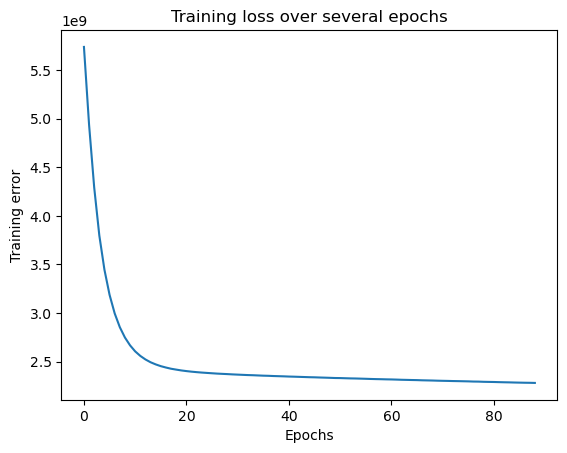

In [10]:
plt.plot(range(0, len(losses_model1)), losses_model1)
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.title('Training loss over several epochs')
plt.show()